# RecMetrics

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

import recmetrics


# Airbnb Dataset

In [65]:
ratings = pd.read_csv('user_rating.csv')
ratings.reset_index(drop=True, inplace=True)

In [66]:
#only consider ratings from users who have rated over n movies
n=1
users = ratings["userId"].value_counts()
users = users[users>n].index.tolist()

In [67]:
ratings = ratings.query('userId in @users')
print(ratings.shape)
ratings.head(3)

(11916, 3)


,userId,rating,listingId
0,8726758,2.0,2818
3,56663354,3.0,2818
52,24554860,4.0,2818


## Long Tail Plot Example

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


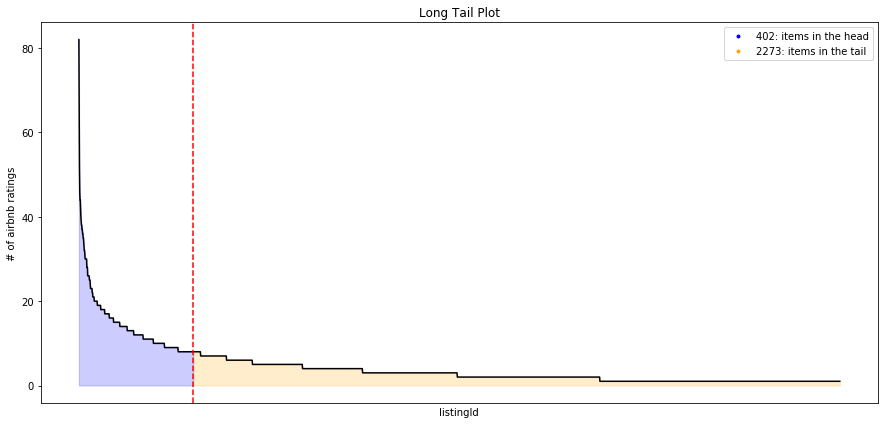

In [68]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="listingId", 
             interaction_type="airbnb ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender

## Format data for Surprise

In [69]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'listingId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [70]:
algo = SVD()
algo.fit(trainset)

In [88]:
test = algo.test(testset)
test = pd.DataFrame(test)

In [73]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='listingId', values='cf_predictions').fillna(0)

In [74]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [76]:
#get example prediction
get_users_predictions(18574384, 10, cf_model)

[15780515,
 2818,
 19339775,
 19614533,
 19606155,
 19584902,
 19559154,
 19527617,
 19480924,
 19423489]

In [77]:
test = test.copy().groupby('userId', as_index=False)['listingId'].agg({'actual': (lambda x: list(set(x)))})

In [78]:
test = test.set_index("userId")

In [81]:
# make recommendations for all members in the test data
cf_recs = [] = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
3268,[768737],"[768737, 2818, 19384110, 19616960, 19614533, 1...","[35927687, 1814121, 654931, 694850, 82482, 785..."
25161,[82482],"[82482, 2818, 19667168, 19616960, 19614533, 19...","[35927687, 1814121, 654931, 694850, 82482, 785..."
29300,"[19184032, 12058561]","[19184032, 12058561, 2818, 19384110, 19614533,...","[35927687, 1814121, 654931, 694850, 82482, 785..."
33359,[2535685],"[2535685, 2818, 19384110, 19614533, 19606155, ...","[35927687, 1814121, 654931, 694850, 82482, 785..."
38048,[31373405],"[31373405, 2818, 19339775, 19606155, 19584902,...","[35927687, 1814121, 654931, 694850, 82482, 785..."


# Recall

In [49]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [52]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.8284313725490197,
 0.9803921568627452,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

# Mark Plot

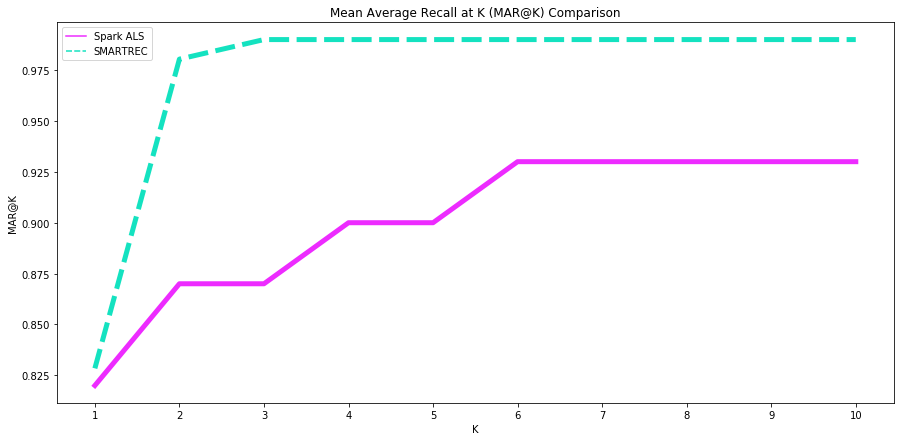

In [91]:
# MARK Plot based upon the derived recall
# pySpark ALS vs real-time collaborative-based filtering
pyCol = [0.82,
 0.87,
 0.87,
 0.90,
 0.90,
 0.93,
 0.93,
 0.93,
 0.93,
 0.93]

neoCol = [0.8284313725490197,
 0.9803921568627452,
 0.99,
 0.99,
 0.99,
 0.99,
 0.99,
 0.99,
 0.99,
 0.99]

mark_scores = [pyCol, neoCol]
index = range(1,10+1)
names = ['Spark ALS', 'SMARTREC']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

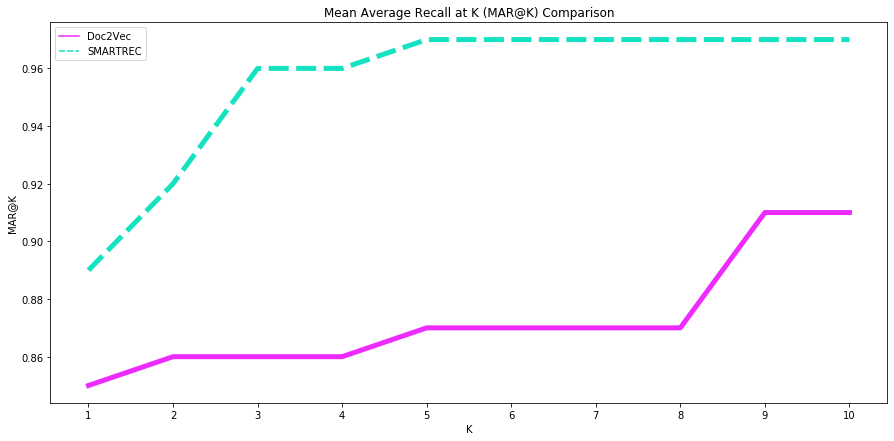

In [93]:
# Doc2Vec vs real-time content-based filtering
Doc2Vec = [0.85,
 0.86,
 0.86,
 0.86,
 0.87,
 0.87,
 0.87,
 0.87,
 0.91,
 0.91]

neoContent = [0.89,
 0.92,
 0.96,
 0.96,
 0.97,
 0.97,
 0.97,
 0.97,
 0.97,
 0.97]

mark_scores = [Doc2Vec, neoContent]
index = range(1,10+1)
names = ['Doc2Vec', 'SMARTREC']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

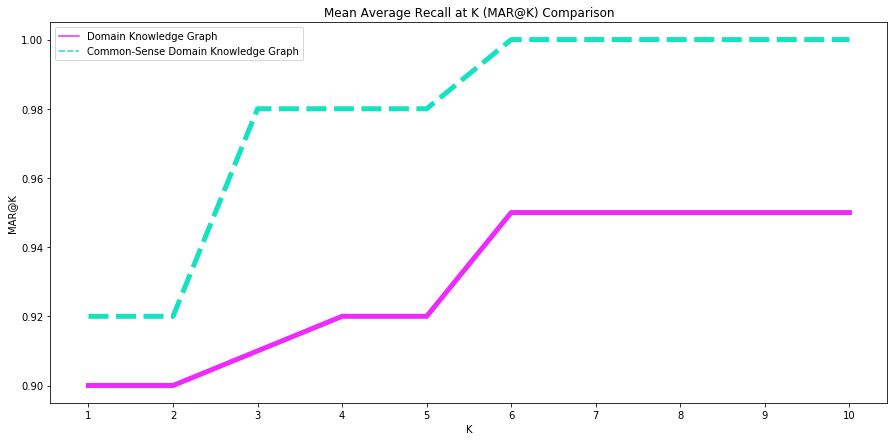

In [95]:
# 
domain_graph = [0.90,
 0.90,
 0.91,
 0.92,
 0.92,
 0.95,
 0.95,
 0.95,
 0.95,
 0.95]

common_sense_graph = [0.92,
 0.92,
 0.98,
 0.98,
 0.98,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

mark_scores = [domain_graph, common_sense_graph]
index = range(1,10+1)
names = ['Domain Knowledge Graph', 'Common-Sense Domain Knowledge Graph']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)